Generate spatial index for catchments based on their topology

Save parent catchment info for every child catchment so that it can be quickly queried, O(n), eventually it is much faster with column value indices.

![Catchments Index](catchment_index.png "Catchments Index")

So, for every parent of a given catchment, a new feature is generated, where an id of its child catchment is saved. This way, all parent catchment ids can be found using a single query.

Note, that rivers index is generated using QGIS: __Join attributes by location__ tool. 

Before join, HydroBASINS layer was converted to contain only a single field HYBAS_ID - changed to text to avoid int overflow. Used __Refactor field__ tool.

hydro-engine\data\HydroBASINS\l05\hybas_lev05_v1c_id.dbf 

In [1]:
%matplotlib inline

import glob
import os
import logging
import sys
import json

import math

import shapefile

import shapely.geometry, shapely.wkt
import shapely as sl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pylab

In [2]:
pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

In [3]:
def generate_index(src, dst):
    shp = shapefile.Reader(src)
    
    # 1. fill directed graph
    graph = nx.DiGraph()
    
    list_hybas_id = [r[0] for r in shp.records()]
    list_next_down = [r[1] for r in shp.records()]
    list_shape_box = [s.bbox for s in shp.shapes()]

    edges = zip(list_hybas_id, list_next_down)

    edges = [e for e in edges if e[1] != 0]
    edges = [e for e in edges if e[0] != 0]

    graph.add_nodes_from([(hybas_id) for (hybas_id) in list_hybas_id])
    graph.add_edges_from([(node_from, node_to) for (node_from, node_to) in edges])

    # 2. traverse parent nodes
    index = []
    for r in zip(list_hybas_id, list_shape_box):
        hybas_id = r[0]
        bbox = r[1]
        x0 = bbox[0]
        x1 = bbox[2]
        y0 = bbox[1]
        y1 = bbox[3]
        
        poly = [[[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]]
        
        parents = nx.bfs_predecessors(graph.reverse(), hybas_id)
        
        for parent in zip(parents.keys(), parents.values()):
            index.append([hybas_id, parent[0], parent[1], poly])
            
        # endorheic
        if len(parents) == 0:
            index.append([hybas_id, 0, hybas_id, poly])
        
    return index

    # 3. write
    
    print('{0} -> {1}'.format(src, dst))
    print(len(shp.shapes()))
    pass

In [ ]:
files = glob.glob('../data/HydroBASINS/*lev09*.shp')

import geojson

l = None
for src in files: 
    file_dir = os.path.dirname(src)
    file_name = os.path.basename(src)
    
    dst = '../data/HydroBASINS_indexed/' + file_name

    print('Processing {0} ...'.format(src))
    
    index = generate_index(src, dst)

    w = shapefile.Writer(shapeType=shapefile.POLYGON)
    w.field('HYBAS_ID', 'N', 16)
    w.field('PARENT_FROM', 'N', 16)
    w.field('PARENT_TO', 'N', 16)
    
    features = []
    for i in index:
        w.poly(i[3])
        
        w.record(i[0], i[1], i[2])
        
    w.save(dst)

Processing ../data/HydroBASINS\hybas_lev09_v1c.shp ...


In [156]:
w = shapefile.Writer(shapefile.POINT)
w.point(1,1)
w.point(3,1)
w.point(4,3)
w.point(2,2)
w.field('FIRST_FLD', 'N',16)
w.field('SECOND_FLD','C','40')
w.record(1,'Point')
w.record(1,'Point')
w.record(2,'Point')
w.record(3,'Point')
w.save('s')

DONE

In [109]:
shp = shapefile.Reader('../data/HydroBASINS\hybas_af_lev05_v1c.shp')

# 1. fill directed graph
graph = nx.DiGraph()

# 2. traverse all parent nodes
list_hybas_id = [r[0] for r in shp.records()]
list_next_down = [r[1] for r in shp.records()]

edges = zip(list_hybas_id, list_next_down)

edges = [e for e in edges if e[1] != 0]
edges = [e for e in edges if e[0] != 0]

graph.add_nodes_from([(hybas_id) for (hybas_id) in list_hybas_id])
graph.add_edges_from([(node_from, node_to) for (node_from, node_to) in edges])

In [110]:
len(graph.nodes())

1028

In [111]:
len(graph.edges())

550

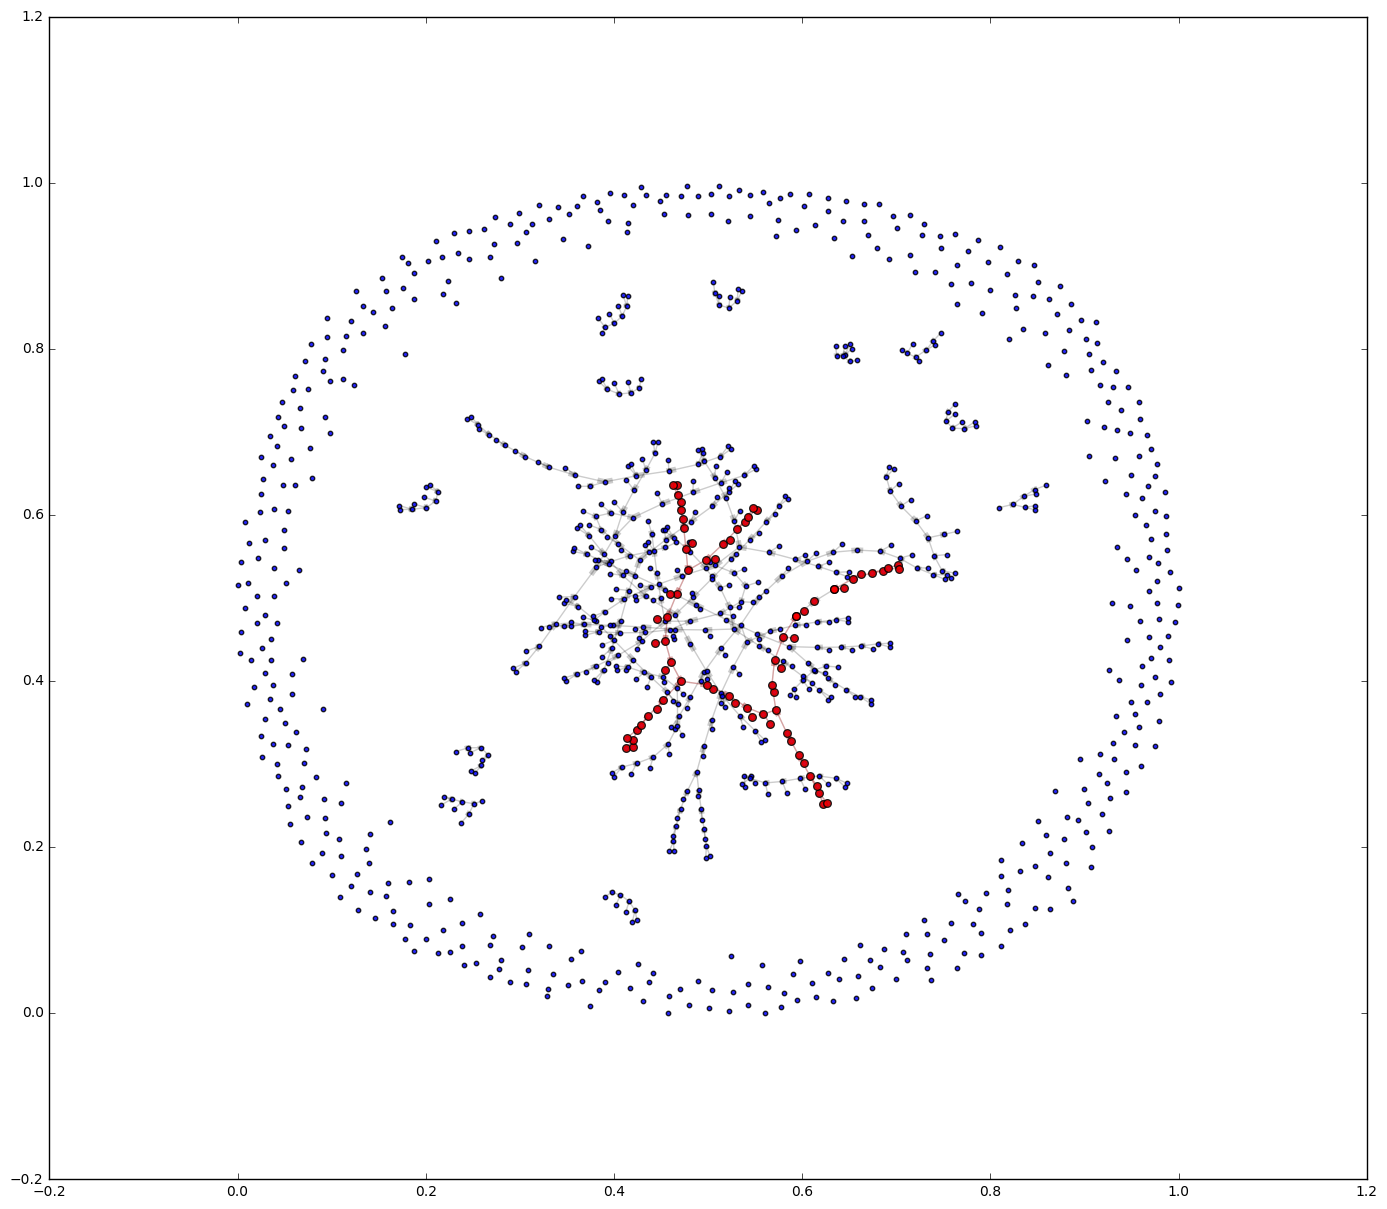

In [205]:
pos = nx.  (nx.Graph(graph), iterations=50, scale=1.0)

nx.draw_networkx_nodes(graph, pos, node_color='b', alpha=0.85, node_size=10)
nx.draw_networkx_edges(graph, pos, alpha=0.2)


# Niger: https://code.earthengine.google.com/0a846953681587649ed9bc6deee974cf
start_node = 1050022420

# traverse up, DFS
parent_nodes = graph.subgraph(nx.dfs_predecessors(graph.reverse(), start_node))

nx.draw_networkx_edges(parent_nodes, pos, edge_color='r', alpha=0.2)

nx.draw_networkx_nodes(parent_nodes, pos, node_color='r', alpha=0.85, node_size=30)

nx.draw_networkx_nodes(graph.subgraph([start_node]), pos, node_color='r', alpha=0.85, node_size=30)

nx.draw_networkx_nodes(graph.subgraph(graph.predecessors(start_node)), pos, node_color='r', alpha=0.85, node_size=30)

In [116]:
graph.predecessors(start_node)

[1050909890, 1050909900]

In [120]:
predecesors = nx.bfs_predecessors(graph.reverse(), start_node)

In [128]:
list(predecesors.keys())

[1050635010,
 1050741380,
 1050737110,
 1050874630,
 1050839560,
 1050680300,
 1050722570,
 1050635020,
 1050513090,
 1050870030,
 1050827040,
 1050874640,
 1050668760,
 1050715340,
 1050669460,
 1050827030,
 1050736280,
 1050694020,
 1050870170,
 1050669470,
 1050680480,
 1050839280,
 1050668450,
 1050513230,
 1050888070,
 1050887720,
 1050515500,
 1050603890,
 1050742280,
 1050741300,
 1050761270,
 1050710380,
 1050515770,
 1050747470,
 1050677950,
 1050722720,
 1050909890,
 1050846020,
 1050641670,
 1050677960,
 1050742220,
 1050909900,
 1050710240,
 1050845560,
 1050682900,
 1050747640,
 1050690130,
 1050893000,
 1050696660,
 1050736270,
 1050577750,
 1050760280,
 1050715100,
 1050689850,
 1050577760,
 1050760290,
 1050652110,
 1050603880,
 1050651900,
 1050737100,
 1050755820,
 1050514030,
 1050761260,
 1050909040,
 1050908780,
 1050694130,
 1050892990,
 1050513910,
 1050755960,
 1050683010,
 1050641660,
 1050696830]